In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pyaccel
import pymodels
from apsuite.optics_analysis import TuneCorr, OpticsCorr
from idanalysis import optics as optics
from mathphys.functions import load_pickle
from apsuite.dynap import DynapXY

In [51]:
def create_ids(
        fname, nr_steps=None, rescale_kicks=None, rescale_length=None):
    # create IDs
    nr_steps = nr_steps or 40
    rescale_kicks = rescale_kicks if rescale_kicks is not None else 1.0
    rescale_length = \
        rescale_length if rescale_length is not None else 1
    IDModel = pymodels.si.IDModel
    delta52 = IDModel(
        subsec=IDModel.SUBSECTIONS.ID10SB,
        file_name=fname,
        fam_name='DELTA52', nr_steps=nr_steps,
        rescale_kicks=rescale_kicks, rescale_length=rescale_length)
    ids = [delta52, ]
    return ids

def calc_twiss(model, si):
    twiss0, *_ = pyaccel.optics.calc_twiss(model)
    twiss1, *_ = pyaccel.optics.calc_twiss(si)

    print('tune x: {:.4f}'.format(twiss0.mux[-1]/(2*np.pi)))
    print('tune y: {:.4f}'.format(twiss0.muy[-1]/(2*np.pi)))
    print()
    print('tune x: {:.4f}'.format(twiss1.mux[-1]/(2*np.pi)))
    print('tune y: {:.4f}'.format(twiss1.muy[-1]/(2*np.pi)))
    return twiss0, twiss1

def correct_beta(si, straight_nr, knobs, goal_beta, goal_alpha):
    dk_tot = np.zeros(len(knobs))
    for i in range(7):
        dk, k = optics.correct_symmetry_withbeta(
            si, straight_nr, goal_beta, goal_alpha)
        if i == 0:
            k0 = k
        print('iteration #{}, \u0394K: {}'.format(i+1, dk))
        dk_tot += dk
    delta = dk_tot/k0
    stg = str()
    for i, fam in enumerate(knobs):
        stg += '{:<9s} \u0394K: {:+9.3f} % \n'.format(
            fam, 100*delta[i])
    print(stg)
    return si

def plot_beta_beating(twiss0, twiss1):
    spos = twiss0.spos
    bbtx = (twiss1.betax - twiss0.betax)/twiss0.betax
    bbty = (twiss1.betay - twiss0.betay)/twiss0.betay

    plt.plot(1e2*bbtx, color='b', label='x')
    plt.plot(1e2*bbty, color='r', label='y')
    plt.ylabel('Beta beating [%]')
    plt.xlabel('spos [m]')
    plt.legend()
    plt.show()

def analysis_dynapt(model):
    model.radiation_on = 0
    model.cavity_on = False
    model.vchamber_on = True

    dynapxy = DynapXY(model)
    dynapxy.params.x_nrpts = 100
    dynapxy.params.y_nrpts = 80
    dynapxy.params.nrturns = 2*1024
    print(dynapxy)
    dynapxy.do_tracking()
    dynapxy.process_data()
    fig, axx, ayy = dynapxy.make_figure_diffusion(
        orders=(1, 2, 3, 4),
        nuy_bounds=(14.12, 14.45),
        nux_bounds=(49.05, 49.50))
        
    return fig

def get_goal_parameters(twiss0, locs_beta):
    goal_tunes = np.array([twiss0.mux[-1]/2/np.pi, twiss0.muy[-1]/2/np.pi])
    goal_beta = np.array(
                    [twiss0.betax[locs_beta],
                     twiss0.betay[locs_beta]])
    goal_alpha = np.array(
                    [twiss0.alphax[locs_beta],
                     twiss0.alphay[locs_beta]])
    return goal_beta, goal_tunes, goal_alpha

def correct_tunes(si, goal_tunes, twiss1):
    tunes = twiss1.mux[-1]/np.pi/2, twiss1.muy[-1]/np.pi/2
    print('init    tunes: {:.9f} {:.9f}'.format(tunes[0], tunes[1]))
    for i in range(2):
        optics.correct_tunes_twoknobs(
            si, goal_tunes, knobs_out=None)
        twiss, *_ = pyaccel.optics.calc_twiss(si)
        tunes = twiss.mux[-1]/np.pi/2, twiss.muy[-1]/np.pi/2
        print('iter #{} tunes: {:.9f} {:.9f}'.format(
            i+1, tunes[0], tunes[1]))
    print('goal    tunes: {:.9f} {:.9f}'.format(
        goal_tunes[0], goal_tunes[1]))
    return si

In [52]:
fname = './results/model/kickmaps/tests/kickmap-ID_width45_phaseneg13p125_gap26p2_only_x.txt'

{'QFB_ID': [2912, 2952], 'QDB1_ID': [2906, 2958], 'QDB2_ID': [2918, 2946]}
[2906, 2959]
tune x: 49.0960
tune y: 14.1518

tune x: 49.0966
tune y: 14.1518


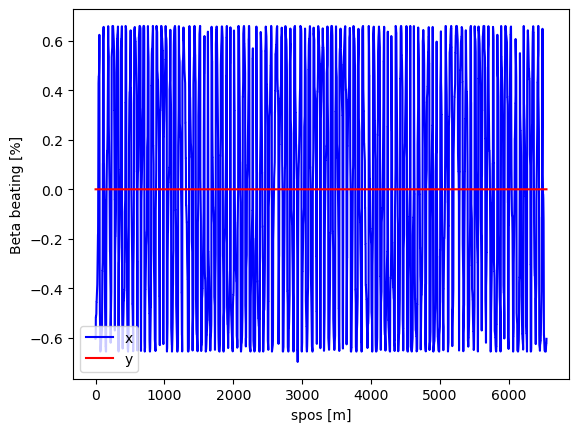

iteration #1, ΔK: [ 1.03324850e-03 -7.25127827e-04  3.96156479e-05]
iteration #2, ΔK: [ 1.01250341e-05 -7.00692768e-06  4.08429608e-07]
iteration #3, ΔK: [ 1.06514301e-09 -7.37995744e-10  4.27901219e-11]
iteration #4, ΔK: [ 2.95721428e-14 -5.75674561e-14 -6.29882971e-15]
iteration #5, ΔK: [ 2.87137456e-14 -2.95992986e-14 -8.06054029e-16]
iteration #6, ΔK: [-4.63497382e-14  7.08955986e-14  5.96881398e-15]
iteration #7, ΔK: [-7.41185847e-15  1.52304239e-14  1.74064080e-15]
QFB_ID    ΔK:    +0.025 % 
QDB1_ID   ΔK:    +0.036 % 
QDB2_ID   ΔK:    -0.001 % 



In [53]:
ids = create_ids(fname=fname)
si = pymodels.si.create_accelerator(ids=ids)
model = pymodels.si.create_accelerator()


model.cavity_on = False
model.radiation_on = 0

_, knobs, _ = optics.symm_get_knobs(si, straight_nr=10, allquads=False)
locs_beta = optics.symm_get_locs_beta(knobs)
print(knobs)
print(locs_beta)

twiss0, twiss1 = calc_twiss(model, si)
plot_beta_beating(twiss0, twiss1)
goal_beta, goal_tunes, goal_alpha = get_goal_parameters(twiss0, locs_beta)
si = correct_beta(si, 10, knobs, goal_beta, goal_alpha)
twiss2, *_ = pyaccel.optics.calc_twiss(si)

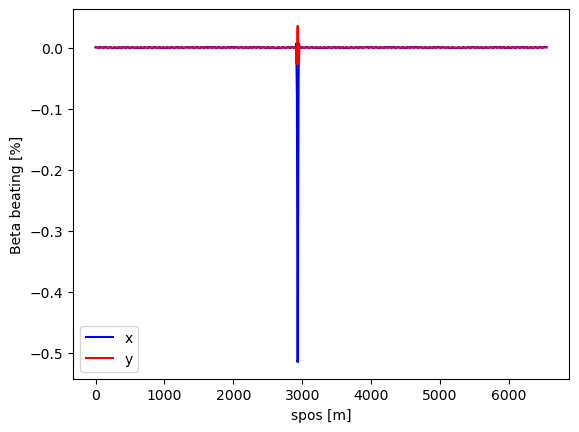

In [54]:
%matplotlib inline
plot_beta_beating(twiss0, twiss2)

nrturns      : 2048
turn_by_turn : True
x_nrpts      : 100
y_nrpts      : 80
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)

 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?


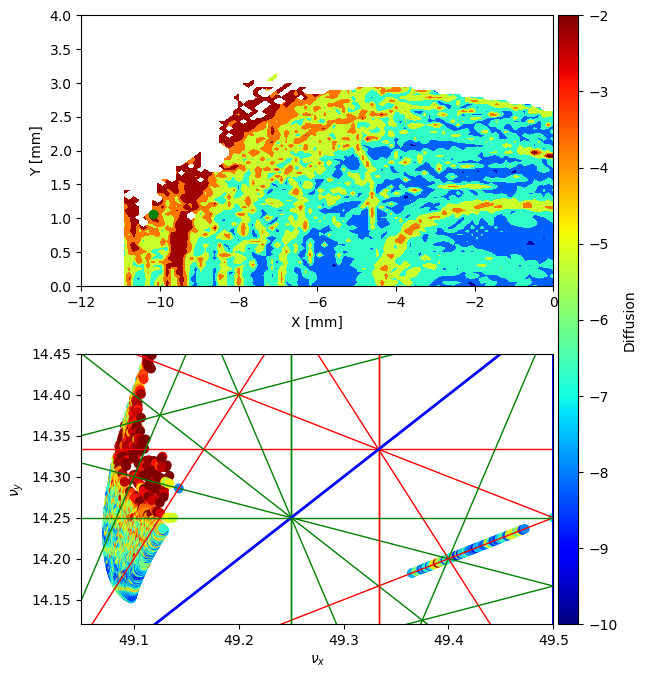

In [55]:
fig = analysis_dynapt(si)

init    tunes: 49.097453125 14.151759478
iter #1 tunes: 49.095966560 14.151790361
iter #2 tunes: 49.095966560 14.151790361
goal    tunes: 49.095966634 14.151790358
tune x: 49.0960
tune y: 14.1518

tune x: 49.0960
tune y: 14.1518


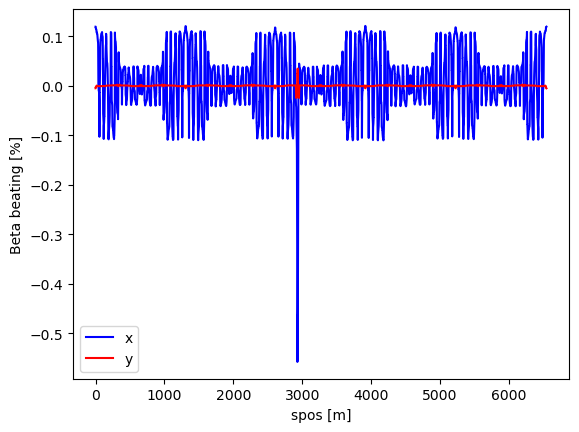

In [56]:
si = correct_tunes(si, goal_tunes, twiss2)
twiss0, twiss3 = calc_twiss(model, si)
plot_beta_beating(twiss0, twiss3)

nrturns      : 2048
turn_by_turn : True
x_nrpts      : 100
y_nrpts      : 80
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)

 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?


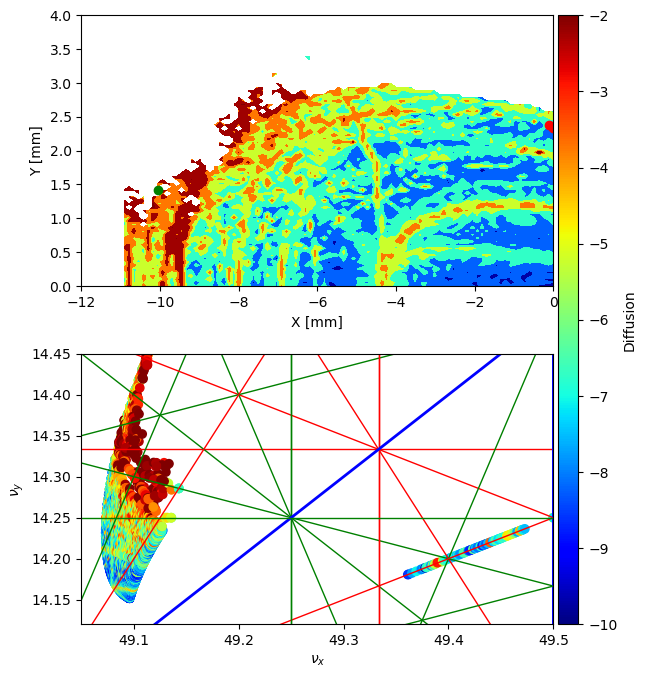

In [57]:
fig2 = analysis_dynapt(si)

{'QFB_ID': [2912, 2952], 'QDB1_ID': [2906, 2958], 'QDB2_ID': [2918, 2946]}
[2906, 2959]
tune x: 49.0960
tune y: 14.1518

tune x: 49.0953
tune y: 14.1518


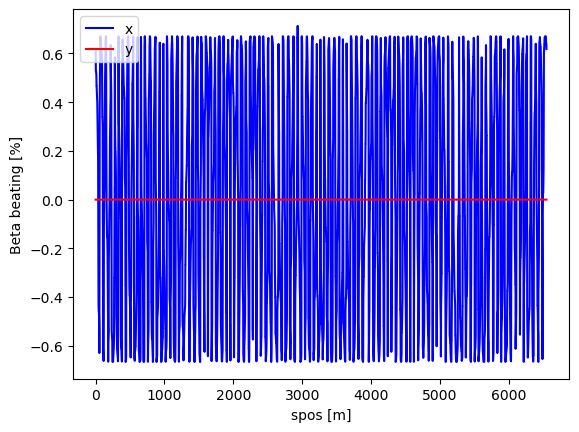

iteration #1, ΔK: [-1.06772553e-03  7.48875101e-04 -3.95243681e-05]
iteration #2, ΔK: [ 1.04634366e-05 -7.23726317e-06  4.07661818e-07]
iteration #3, ΔK: [ 1.15938797e-09 -8.03610186e-10  4.48271942e-11]
iteration #4, ΔK: [ 2.29317164e-14 -1.00457900e-13 -1.62568706e-14]
iteration #5, ΔK: [-3.62787044e-14  7.33714623e-14  8.37406868e-15]
iteration #6, ΔK: [-6.78446905e-15  8.80106196e-14  1.66267533e-14]
iteration #7, ΔK: [ 2.00716986e-14 -6.01617328e-14 -8.60008662e-15]
QFB_ID    ΔK:    -0.026 % 
QDB1_ID   ΔK:    -0.037 % 
QDB2_ID   ΔK:    +0.001 % 



In [58]:
%matplotlib inline

ids = create_ids(fname, rescale_kicks=-1)
si_inv = pymodels.si.create_accelerator(ids=ids)
si_inv.cavity_on = False
si_inv.radiation_on = 0

_, knobs, _ = optics.symm_get_knobs(si_inv, straight_nr=10, allquads=False)
locs_beta = optics.symm_get_locs_beta(knobs)
print(knobs)
print(locs_beta)

twiss0, twiss4 = calc_twiss(model, si_inv)
plot_beta_beating(twiss0, twiss4)
goal_beta, goal_tunes, goal_alpha = get_goal_parameters(twiss0, locs_beta)
si_inv = correct_beta(si_inv, 10, knobs, goal_beta, goal_alpha)
twiss5, *_ = pyaccel.optics.calc_twiss(si_inv)

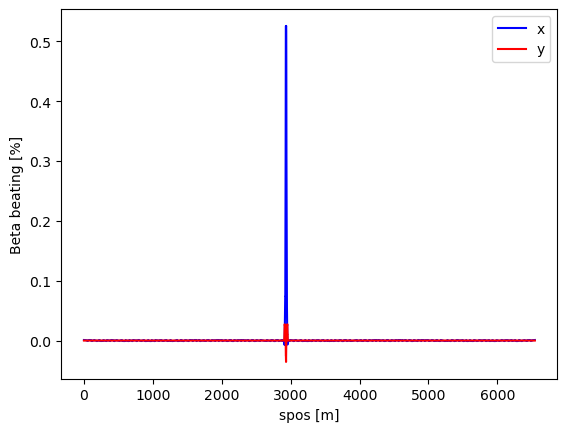

In [59]:
plot_beta_beating(twiss0, twiss5)

nrturns      : 2048
turn_by_turn : True
x_nrpts      : 100
y_nrpts      : 80
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)

 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?


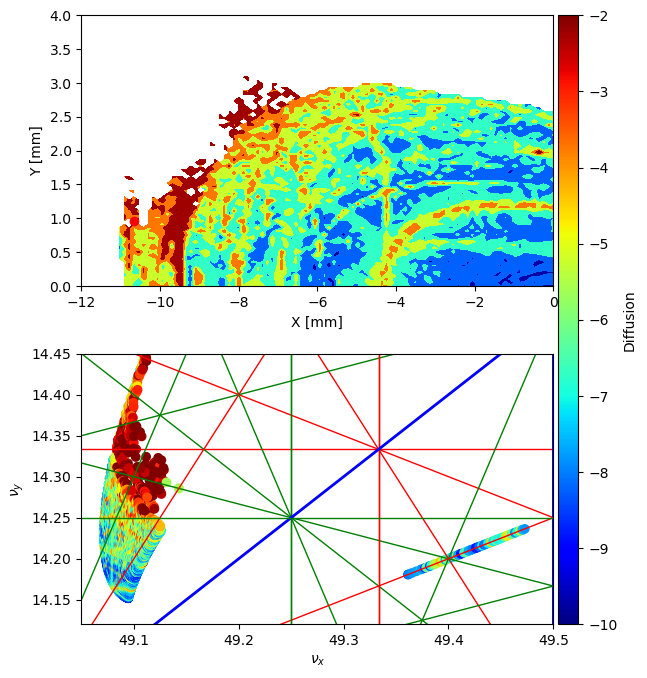

In [60]:
fig3 = analysis_dynapt(si_inv)

init    tunes: 49.094466049 14.151821571
iter #1 tunes: 49.095966543 14.151790368
iter #2 tunes: 49.095966543 14.151790368
goal    tunes: 49.095966634 14.151790358
tune x: 49.0960
tune y: 14.1518

tune x: 49.0960
tune y: 14.1518


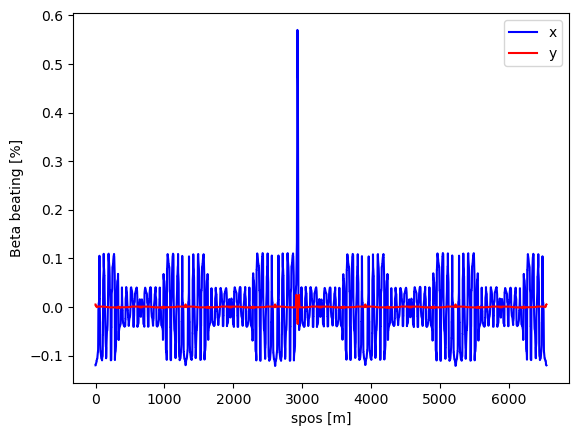

In [61]:
si_inv = correct_tunes(si_inv, goal_tunes, twiss5)
twiss0, twiss6 = calc_twiss(model, si_inv)
plot_beta_beating(twiss0, twiss6)

nrturns      : 2048
turn_by_turn : True
x_nrpts      : 100
y_nrpts      : 80
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)

 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?
 OSCILLATION DE L''ENCADREMENT ?


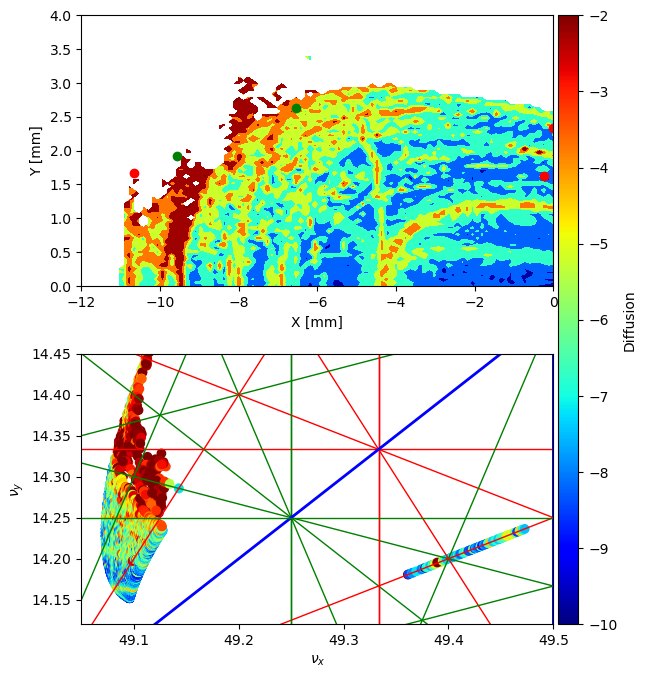

In [62]:
fig4 = analysis_dynapt(si_inv)

In [66]:
fig4.savefig('inverted')
fig2.savefig('non_inverted')

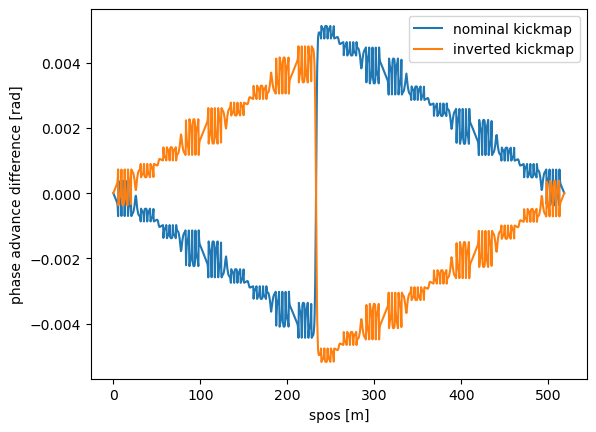

In [63]:
plt.plot(twiss0.spos, twiss3.mux-twiss0.mux, label='nominal kickmap')
plt.plot(twiss0.spos, twiss6.mux-twiss0.mux, label='inverted kickmap')
plt.ylabel('phase advance difference [rad]')
plt.xlabel('spos [m]')
plt.legend()

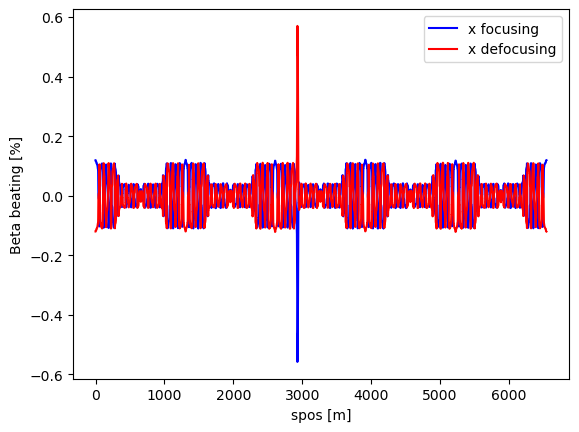

In [64]:
%matplotlib inline
bbtx = (twiss3.betax - twiss0.betax)/twiss0.betax
bbtx_inv = (twiss6.betax - twiss0.betax)/twiss0.betax

plt.plot(1e2*bbtx, color='b', label='x focusing')
plt.plot(1e2*bbtx_inv, color='r', label='x defocusing')
plt.ylabel('Beta beating [%]')
plt.xlabel('spos [m]')
plt.legend()
plt.show()

In [65]:
ids = create_ids(fname, rescale_kicks=1)
test_model = pymodels.si.create_accelerator(ids=ids)
correct_tunes(test_model, goal_tunes, )

TypeError: correct_tunes() missing 1 required positional argument: 'twiss1'